In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft

# OFDM Transmitter

#### ToDo:
- functions for grouping
- classes for grouping

In [ ]:
# bit_stream = np.random.randint(0,2,7752*4)
# np.save('bit_stream.npy', bit_stream)

In [ ]:
# CONSTANTS

NUM_SC = 612
NUM_SLOTS = 14

In [ ]:
# Generate Data and modulate
bit_stream = np.load('bit_stream.npy')
qam_map = {
    (0,0,0,0):  1 + 1j,
    (0,0,0,1):  1 + 3j,
    (0,0,1,1):  1 - 3j,
    (0,0,1,0):  1 - 1j,

    (0,1,0,0):  3 + 1j,
    (0,1,0,1):  3 + 3j,
    (0,1,1,1):  3 - 3j,
    (0,1,1,0):  3 - 1j,

    (1,1,0,0): -3 + 1j,
    (1,1,0,1): -3 + 3j,
    (1,1,1,1): -3 - 3j,
    (1,1,1,0): -3 - 1j,

    (1,0,0,0): -1 + 1j,
    (1,0,0,1): -1 + 3j,
    (1,0,1,1): -1 - 3j,
    (1,0,1,0): -1 - 1j,
}

qam_demap = {v: k for k, v in qam_map.items()}

def qam_mapping(bit_stream):
  L = len(bit_stream)
  bit_grps = [tuple(bit_stream[i:i+4]) for i in range(0, L, 4)]
  qam_symbols = [qam_map[grp] for grp in bit_grps]
  return qam_symbols



In [ ]:
data_symbols = qam_mapping(bit_stream)
resource_grid = np.zeros((NUM_SC, NUM_SLOTS), dtype=complex)
dmrs_indices = np.linspace(10, 8567, 816, dtype=int)  # using a linear DMRS fashion

dmrs_positions = np.array([(i % NUM_SC,  i // NUM_SC) for i in dmrs_indices])
dmrs_symbols = np.array([-1 + 1j, 3 + 1j, 1 - 1j, 1 + 3j])

# sc_idx = subcarrier index, sym_idx = OFDM symbol index
for i, (sc_idx, sym_idx) in enumerate(dmrs_positions):
    resource_grid[sc_idx, sym_idx] = dmrs_symbols[i % 4]

dmrs_mask = np.zeros((NUM_SC, NUM_SLOTS), dtype=bool)
for sc_idx, sym_idx in dmrs_positions:
    dmrs_mask[sc_idx, sym_idx] = True

# Place Data Symbols in the Grid
n = 0 # No. of data symbols counter
for sym_idx in range(NUM_SLOTS):
  for sc_idx in range(NUM_SC):
    if not dmrs_mask[sc_idx, sym_idx]:
      resource_grid[sc_idx, sym_idx] = data_symbols[n]
      n +=1

Pilots placed: 816
Data symbols used: 7752
Empty resource elements: 0


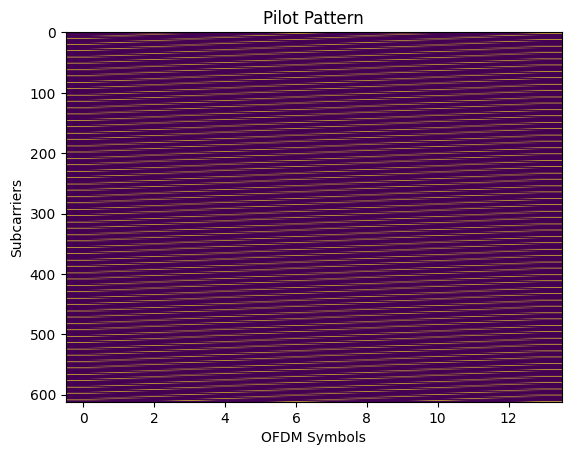

In [ ]:
# Resource Grid verification
print(f"Pilots placed: {np.sum(dmrs_mask)}")  # Should be 816
print(f"Data symbols used: {n}")  # Should be 7752
empty_res = np.sum(resource_grid == 0)
print(f"Empty resource elements: {empty_res}")  # Should be 0
plt.imshow(dmrs_mask, aspect='auto')  # .T for proper time/freq orientation
plt.ylabel('Subcarriers')
plt.xlabel('OFDM Symbols')
plt.title('Pilot Pattern')

# np.save('resource_grid.npy', Resource_Grid)

if not (resource_grid == np.load('resource_grid.npy')).all():
  raise ValueError("Resource Grid not matching")

In [ ]:
# OFDM and Transmission
# Extract each OFDM symbol (column) for processing
time_domain_symbols = []
for sym_idx in range(NUM_SLOTS):
    frequency_domain_symbol = Resource_Grid[:, sym_idx]  # 612 subcarriers
    time_domain_symbol = np.fft.ifft(frequency_domain_symbol, 612)
    time_domain_symbols.append(time_domain_symbol)
# Add Cyclic Prefix
cp_length = 144
symbols_with_cp = []
for time_symbol in time_domain_symbols:
    symbol_with_cp = np.concatenate([time_symbol[-cp_length:], time_symbol])
    symbols_with_cp.append(symbol_with_cp)
transmitted_signal = np.concatenate(symbols_with_cp)

NameError: name 'Resource_Grid' is not defined

## OFDM Transmission System Summary
So far, we have implemented the OFDM Transmission. We generated a bitstream, applied QAM Mapping, then added pilot symbols. Here, we could have added pilots before modulation and modulated the pilots too, but that was pretty confusing to implement - as I had to add 4 bits and they will be modulated and DMRS Indices are hard to calculate. So, I added the QAM symbols corresponding to inputs 1000, 0100, 0010 and 0001 as DMRS symbols.
Then, the symbols are arranged in the 612 * 14 Resource Grid and the same is plotted for reference.

# CHANNEL
 We use the TDL-C Channel Model. In TDL (Tapped Delay Line) channel models, the relative powers of the taps (or paths) are typically specified relative to the strongest path, which is often assigned a power of 0 dB. The other taps have lower power levels, reflecting the attenuation of signals arriving at different delays due to multipath propagation. The relative power of each tap indicates how much weaker it is compared to the strongest tap. For example, if a tap has a relative power of -10 dB, it means that its power is 10 dB lower than the strongest tap.

In [ ]:
# Channel
Avg_Path_Gains = np.array([-13.4000, 0, -2.2000, -4.0000, -6.0000,	-8.2000, -9.9000, -10.5000,	-7.5000,	-15.9000,
                  -6.6000,	-16.7000,	-12.4000, -15.2,	-10.8,	-11.300,	-12.7,	-16.2,	-18.3,	-18.9	,-16.6, -19.9, -29.7])
Channel_Path_Delays = np.array([0,	1.1457e-07,	1.2075e-07,	1.7604e-07,	1.383e-07,	1.6125e-07,	2.0124e-07,	1.725e-07,	2.2854e-07,
                       4.6125e-07,	5.6934e-07,	6.6726e-07,	6.5154e-07,	7.4826e-07,	7.5357e-07,	9.1746e-07,	1.2243e-06,	1.3373e-06,	1.3709e-06,
                       1.439e-06,	1.502e-06,	1.5913e-06,	2.8976e-06])
maxChDelay = 94
SNRdB = 10

def Jakes_model(n, fd, fs):
  """ n :  no. of samples
      fd: doppler shift
      fs: sampling frequency
  """
  N = 16 # No. of scattering points
  h = np.zeros(num_samples, dtype=complex)
  for n in range(N):
    t = np.arange(N)/fs


In [ ]:

def __init__(self, channel_type='TDLC-A', delay_spread=300e-9, doppler=0):
    self.taps = self.get_channel_taps(channel_type)
    self.delay_spread = delay_spread
    self.doppler = doppler

def get_channel_taps(self, channel_type):
    # Define tap delays and powers for different TDLC models
    # TDLC-A, TDLC-B, TDLC-C profiles
    pass

def apply_channel(self, signal):
    # Apply multipath fading
    pass

In [ ]:
def ls_channel_estimation(received_pilots, transmitted_pilots):
    # H_est = Y_pilot / X_pilot (element-wise division)
    return received_pilots / transmitted_pilots

def interpolate_channel(pilot_estimates, pilot_positions, grid_size):
    # Linear/cubic interpolation between pilot positions
    # Both in frequency and time domain
    pass

In [ ]:
def frequency_domain_equalization(received_data, channel_estimates):
    # Zero-forcing equalization: Y_eq = Y_received / H_estimated
    return received_data / channel_estimates

def mmse_equalization(received_data, channel_estimates, noise_variance):
    # MMSE equalization for better performance
    pass

In [ ]:
def __init__(self):
    self.n_subcarriers = 612
    self.n_symbols = 14
    self.cp_length = 144  # Normal CP for first symbol
    self.cp_length_normal = 144  # Other symbols

def add_cyclic_prefix(self, ofdm_symbols):
    return ofdm_symbols[-self.cplength:] + ofdm_symbols

def remove_cyclic_prefix(self, received_signal):
    return received_signal[self.cplength:]

def ofdm_modulate(self, resource_grid):
    # Convert resource grid to time domain
    pass

def ofdm_demodulate(self, time_signal):
    # Convert time signal back to resource grid
    pass

In [ ]:
def cart_prod(a, b):
  for x in a:
    for y in b:
      yield (x, y)

list(cart_prod(range(3), range(6)))